In [ ]:
%%bash

# If using Python 3.6, replace this line with: source $VIRTUAL_ENV_DIR/python3/bin/activate
source $VIRTUAL_ENV_DIR/python37/bin/activate

# Install latest mxpkg version (to specify version, use syntax: pip install mxpkg==1.1.7)
pip install 'setuptools<58.0.0'
pip install mxpkg --upgrade

# Extra step to install correct thrift version (see: https://code.uberinternal.com/D2889175)
pip uninstall thrift -y && pip install thrift==0.11.0

deactivate
# After this cell runs, restart your notebook kernel and mxpkg should be installed

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from mxpkg.lib import constants
constants.ENABLE_LOCKDOWN = False
constants.ENABLE_LOCKDOWN_DRS = False

from mxpkg.lib.dsw_utils import notebook_init, log_level
from mxpkg.api.switchback import SwitchbackAnalysis
from mxpkg.services.analysis.report_new import SwitchbackAnalysisReportService

notebook_init()
log_level('INFO')
warnings.filterwarnings('ignore')
%matplotlib inline

mxpkg version: 1.2.0
environment: dsw


In [ ]:
SwitchbackAnalysis.show_available_metrics()

In [2]:
METRICS = ['mobility_pickup_defects_over_requests_ratio', 
           'loop_rate_around_pickup_location',
           'dwelling_defect_rate_over_180s',
           'cancel_after_2min_rate',
           'mobility_completed_trips_over_requested_ratio',
           'total_rider_cancelled_trips',
           'total_driver_cancelled_trips',
           # 'rides_cancellation_rate',
           # 'avg_pickup_arrival_ata_sec',
           # 'mobility_avg_pickup_location_error_meter',
           # 'rider_app_crashes_per_user',
           # 'rider_app_sessions'
          ]

METRIC_FILEPATH = 'metrics3.csv'

In [3]:
"""
Cities & Product VVIDs included in *congestion_aware_airport* experiment

Washington D.C. (8): UberX (326, 1186, 20003057, 20014641, 20023537)
"""

sb = SwitchbackAnalysis(
    experiment_name='congestion_aware_airport',
    metric_names=METRICS, 
    segment_filters={
        'product': ['UberX MASTER'], 
        'city': [8]
    },
    segment_types=['city']
)

sb.collect_data()

2023-02-20 23:40:27,519 jaeger_tracing INFO Tracing sampler started with sampling refresh interval 60 sec


02/20/2023 11:41:02 PM Send tier_metadata {'tier': 3} to Queryrunner V2.
02/20/2023 11:41:02 PM  [Polling] 31003d5d-16da-4be0-a291-fed4b0290b5c 
02/20/2023 11:41:02 PM  [Status] created 
02/20/2023 11:41:03 PM  [Status] finished auth check 
02/20/2023 11:41:05 PM  [Status] started waiting to execute 
02/20/2023 11:41:07 PM  [Status] started execution 
02/20/2023 11:41:15 PM  [Status] completed success 
02/20/2023 11:41:15 PM  [Query Success] completed success 


02/20/2023 11:41:18 PM Send tier_metadata {'tier': 3} to Queryrunner V2.
02/20/2023 11:41:18 PM  [Polling] a03f7ac9-74cb-49bf-8143-f1ca076ab055 
02/20/2023 11:41:18 PM  [Status] created 
02/20/2023 11:41:19 PM  [Status] started validation 
02/20/2023 11:41:20 PM  [Status] finished auth check 
02/20/2023 11:41:21 PM  [Status] started execution 
02/20/2023 11:41:47 PM  [Status] completed success 
02/20/2023 11:41:47 PM  [Query Success] completed success 


In [ ]:
sb.run_analysis()
sb.results_barchart()

In [ ]:
sb.time_of_week_plot()

In [ ]:
sb.results_table()

# BYOD

**ePUDOs in Experiment **

| Venue             | ePUDO Zone ID                       |
| ----------------- | ----------------------------------- |
| Capital One Arena     | 60701719-a03f-4e08-b84b-cde701650676
| Nationals Park     | 309fd9a5-321a-4622-b127-71defe1c39d1

In [4]:
from queryrunner_client import Client
qr = Client(consumer_name='piper', user_email='<alias>@uber.com')

In [5]:
query = """
WITH maps_fact_trip_location_table AS (
  SELECT
    COUNT(maps_fact_trip_location.trip_uuid) AS tmp_metric_name_without_conflict_4,
    COUNT(maps_fact_trip_location.trip_uuid) AS ftl_trip_cnt,
    SUM(
      CASE
        WHEN maps_fact_trip_location.status IN ('rider_canceled', 'driver_canceled')
        AND maps_fact_trip_location.trip_cancel_epoch - maps_fact_trip_location.last_dispatch_accept_epoch > 120
        OR CASE
          WHEN maps_fact_trip_location.loops_around_pickup_waste_seconds IS NOT NULL THEN maps_fact_trip_location.loops_around_pickup_waste_seconds
          ELSE 0
        END > 60
        OR CASE
          WHEN maps_fact_trip_location.driver_pickup_dwelling_seconds IS NOT NULL THEN maps_fact_trip_location.driver_pickup_dwelling_seconds
          ELSE 0
        END > 180 THEN 1
        ELSE 0
      END
    ) AS cnt_trip_pickup_defects_w_loop_over_60s,
    SUM(
      CASE
        WHEN maps_fact_trip_location.loops_around_pickup_waste_seconds > 60 THEN 1
        ELSE 0
      END
    ) AS cnt_trip_loop_around_pickup_location,
    SUM(
      CASE
        WHEN CASE
          WHEN maps_fact_trip_location.driver_pickup_dwelling_seconds IS NOT NULL THEN maps_fact_trip_location.driver_pickup_dwelling_seconds
          ELSE 0
        END > 180 THEN 1
        ELSE 0
      END
    ) AS cnt_trip_dwelling_over_180s,
    SUM(
      CASE
        WHEN maps_fact_trip_location.status IN ('rider_canceled', 'driver_canceled')
        AND maps_fact_trip_location.trip_cancel_epoch - maps_fact_trip_location.last_dispatch_accept_epoch > 120 THEN 1
        ELSE 0
      END
    ) AS cnt_trip_cancel_over_120s,
    AVG(LEAST(maps_fact_trip_location.pickup_location_error, 300)) AS pickup_location_error,
    AVG(LEAST(maps_fact_trip_location.normalized_pickup_location_error, 300)) AS normalized_pickup_location_error,
    maps_fact_trip_location.city AS city,
    maps_fact_trip_location.time_bucket AS time_bucket,
    GROUPING(
      maps_fact_trip_location.city,
      maps_fact_trip_location.time_bucket
    ) AS grouping_flag
  FROM
    (
      SELECT
        maps_fact_trip_location.datestr AS datestr,
        CAST(maps_fact_trip_location.city_id AS VARCHAR) AS city,
        maps_fact_trip_location.driver_uuid AS supply_uuid,
        maps_fact_trip_location.client_uuid AS rider_uuid,
        CAST(
          to_unixtime(
            DATE_PARSE(
              REPLACE(
                substr(
                  CAST(
                    maps_fact_trip_location.request_timestamp_utc AS VARCHAR
                  ),
                  1,
                  19
                ),
                'T',
                ' '
              ),
              '%Y-%m-%d %H:%i:%s'
            )
          ) AS BIGINT
        ) * 1000 AS "time",
        CAST(
          maps_fact_trip_location.vehicle_view_id AS VARCHAR
        ) AS vvid,
        maps_fact_trip_location.trip_uuid AS trip_uuid,
        maps_fact_trip_location.city_id AS city_id,
        maps_fact_trip_location.driver_uuid AS driver_uuid,
        maps_fact_trip_location.client_uuid AS client_uuid,
        maps_fact_trip_location.status AS status,
        maps_fact_trip_location.device_os AS device_os,
        maps_fact_trip_location.app_version AS app_version,
        maps_fact_trip_location.request_timestamp_utc AS request_timestamp_utc,
        maps_fact_trip_location.vehicle_view_id AS vehicle_view_id,
        maps_fact_trip_location.driver_pickup_dwelling_seconds AS driver_pickup_dwelling_seconds,
        maps_fact_trip_location.loops_around_pickup_waste_seconds AS loops_around_pickup_waste_seconds,
        maps_fact_trip_location.pickup_waypoint_location_source AS pickup_waypoint_location_source,
        maps_fact_trip_location.pickup_waypoint_location_type AS pickup_waypoint_location_type,
        maps_fact_trip_location.pickup_anchor_confidence AS pickup_anchor_confidence,
        maps_fact_trip_location.trip_cancel_epoch AS trip_cancel_epoch,
        maps_fact_trip_location.last_dispatch_accept_epoch AS last_dispatch_accept_epoch,
        maps_fact_trip_location.is_rider_cancel_at_dispatch AS is_rider_cancel_at_dispatch,
        maps_fact_trip_location.is_rider_cancel_enroute AS is_rider_cancel_enroute,
        maps_fact_trip_location.is_rider_cancel_arrived AS is_rider_cancel_arrived,
        maps_fact_trip_location.count_driver_accepts AS count_driver_accepts,
        maps_fact_trip_location.count_driver_cancels AS count_driver_cancels,
        maps_fact_trip_location.count_driver_cancels_enroute AS count_driver_cancels_enroute,
        maps_fact_trip_location.count_driver_cancels_arrived AS count_driver_cancels_arrived,
        maps_fact_trip_location.is_airport_trip AS is_airport_trip,
        maps_fact_trip_location.destination_airport_code AS destination_airport_code,
        maps_fact_trip_location.dropoff_airport_code AS dropoff_airport_code,
        maps_fact_trip_location.request_airport_code AS request_airport_code,
        maps_fact_trip_location.begintrip_airport_code AS begintrip_airport_code,
        maps_fact_trip_location.is_airport_destination AS is_airport_destination,
        maps_fact_trip_location.is_airport_request AS is_airport_request,
        maps_fact_trip_location.pickup_location_error AS pickup_location_error,
        maps_fact_trip_location.normalized_pickup_location_error AS normalized_pickup_location_error,
        dim_product_type.global_parent_name AS global_product_name,
        (
          CAST(
            to_unixtime(
              DATE_PARSE(
                REPLACE(
                  substr(
                    CAST(
                      maps_fact_trip_location.request_timestamp_utc AS VARCHAR
                    ),
                    1,
                    19
                  ),
                  'T',
                  ' '
                ),
                '%Y-%m-%d %H:%i:%s'
              )
            ) AS BIGINT
          ) * 1000 - 1662696000000
        ) / 2880000 * 2880000 + 1662696000000 AS time_bucket
      FROM
        (
          SELECT
            ft.trip_uuid,
            ft.city_id,
            ft.datestr,
            ft.driver_uuid,
            ft.client_uuid,
            ft.status,
            ft.device_os,
            ft.app_version,
            ft.request_timestamp_utc,
            ft.vehicle_view_id,
            ft.driver_pickup_dwelling_seconds,
            ft.loops_around_pickup_waste_seconds,
            ft.pickup_waypoint_location_source,
            ft.pickup_waypoint_location_type,
            ft.pickup_anchor_confidence,
            ft.pickup_location_error,
            ft.normalized_pickup_location_error,
            a.trip_cancel_epoch,
            a.last_dispatch_accept_epoch,
            a.is_rider_cancel_at_dispatch,
            a.is_rider_cancel_enroute,
            a.is_rider_cancel_arrived,
            a.count_driver_accepts,
            a.count_driver_cancels,
            a.count_driver_cancels_enroute,
            a.count_driver_cancels_arrived,
            f.is_airport_trip,
            f.destination_airport_code,
            f.dropoff_airport_code,
            f.request_airport_code,
            f.begintrip_airport_code,
            CASE
              WHEN f.destination_airport_code IS NOT NULL THEN TRUE
              ELSE FALSE
            END AS is_airport_destination,
            CASE
              WHEN f.request_airport_code IS NOT NULL THEN TRUE
              ELSE FALSE
            END AS is_airport_request
          FROM
            maps_etl.fact_trip_location AS ft
            LEFT JOIN dwh.analytics_trip AS a ON a.trip_uuid = ft.trip_uuid
            AND (
              a.datestr >= '2022-09-08'
              AND a.datestr <= '2022-09-24'
            )
            LEFT JOIN restricted_dwh.fact_trip AS f ON f.uuid = ft.trip_uuid
            AND (
              f.datestr >= '2022-09-08'
              AND f.datestr <= '2022-09-24'
            )
            JOIN epudos.fact_epudo_trip AS e ON e.trip_uuid = ft.trip_uuid
            AND (
              e.datestr >= '2022-09-08'
              AND e.datestr <= '2022-09-24'
              AND e.trip_type = 'pickup'
              AND e.flow_type != 'none'
              AND e.zone_uuid IN ('60701719-a03f-4e08-b84b-cde701650676', '309fd9a5-321a-4622-b127-71defe1c39d1')
            )
          WHERE
            ft.datestr >= '2022-09-09'
            AND ft.datestr <= '2022-09-23'
            AND ft.status <> 'fare_split'
            AND (
              ft.device_os = 'ios'
              AND substr(ft.app_version, 1, 1) = '3'
              OR ft.device_os = 'android'
              AND substr(ft.app_version, 1, 1) = '4'
            )
        ) AS maps_fact_trip_location
        LEFT JOIN dwh.lookup_product_vehicle_view AS lookup_product_vehicle_view ON CAST(
          lookup_product_vehicle_view.vehicle_view_id AS VARCHAR
        ) = CAST(
          maps_fact_trip_location.vehicle_view_id AS VARCHAR
        )
        LEFT JOIN dwh.dim_product_type AS dim_product_type ON dim_product_type.uuid = lookup_product_vehicle_view.product_type_uuid
    ) AS maps_fact_trip_location
  WHERE
    maps_fact_trip_location.global_product_name IN ('UberX MASTER')
    AND maps_fact_trip_location.city IN ('8')
    AND maps_fact_trip_location."time" < 1663905600000
    AND maps_fact_trip_location."time" >= 1662696000000
  GROUP BY
    GROUPING SETS(
      (
        maps_fact_trip_location.city,
        maps_fact_trip_location.time_bucket
      )
    )
),
fact_trip_table AS (
  SELECT
    COUNT(
      CASE
        WHEN fact_trip.status = 'driver_canceled' THEN fact_trip.uuid
        ELSE NULL
      END
    ) AS tmp_metric_name_without_conflict_3,
    COUNT(
      CASE
        WHEN fact_trip.status <> 'fare_split' THEN fact_trip.uuid
        ELSE NULL
      END
    ) AS tmp_metric_name_without_conflict_1,
    COUNT(
      CASE
        WHEN fact_trip.status = 'rider_canceled' THEN fact_trip.uuid
        ELSE NULL
      END
    ) AS tmp_metric_name_without_conflict_0,
    COUNT(
      CASE
        WHEN fact_trip.status <> 'fare_split' THEN fact_trip.uuid
        ELSE NULL
      END
    ) AS mobility_requested_trips,
    COUNT(
      CASE
        WHEN fact_trip.status = 'completed' THEN fact_trip.uuid
        ELSE NULL
      END
    ) AS mobility_completed_trips,
    fact_trip.city AS city,
    fact_trip.time_bucket AS time_bucket,
    GROUPING(fact_trip.city, fact_trip.time_bucket) AS grouping_flag
  FROM
    (
      SELECT
        fact_trip.datestr AS datestr,
        fact_trip.driver_uuid AS supply_uuid,
        CAST(fact_trip.city_id AS VARCHAR) AS city,
        fact_trip.product_type_uuid AS product_type_uuid,
        fact_trip.client_uuid AS rider_uuid,
        CASE
          WHEN fact_trip.dropoff_airport_code IS NOT NULL THEN fact_trip.dropoff_airport_code
          ELSE fact_trip.destination_airport_code
        END AS airport_dropoff_code,
        CASE
          WHEN fact_trip.begintrip_airport_code IS NOT NULL THEN fact_trip.begintrip_airport_code
          ELSE fact_trip.request_airport_code
        END AS airport_pickup_code,
        CAST(fact_trip.vehicle_view_id AS VARCHAR) AS vvid,
        fact_trip.uuid AS uuid,
        GET_HEXAGON_ADDR(fact_trip.request_lat, fact_trip.request_lng, 9) AS hexagon_9,
        fact_trip.uuid AS trip_uuid,
        fact_trip.client_uuid AS user_uuid,
        fact_trip.global_product_name AS global_product_name,
        CAST(
          to_unixtime(
            DATE_PARSE(
              REPLACE(
                substr(
                  CAST(fact_trip.request_timestamp_utc AS VARCHAR),
                  1,
                  19
                ),
                'T',
                ' '
              ),
              '%Y-%m-%d %H:%i:%s'
            )
          ) AS BIGINT
        ) * 1000 AS "time",
        fact_trip.driver_upfront_fare_usd AS driver_upfront_fare_usd,
        fact_trip.upgraded_product_type_uuid AS upgraded_product_type_uuid,
        fact_trip.client_trip_number AS client_trip_number,
        fact_trip.requested_bolt_ons AS requested_bolt_ons,
        fact_trip.toll_amount_local AS toll_amount_local,
        fact_trip.vehicle_category_id AS vehicle_category_id,
        fact_trip.begintrip_timestamp_utc AS begintrip_timestamp_utc,
        fact_trip.commission_rate AS commission_rate,
        fact_trip.rewindtrip_timestamp_local AS rewindtrip_timestamp_local,
        fact_trip.per_minute_fare_usd AS per_minute_fare_usd,
        fact_trip.booking_fee_usd AS booking_fee_usd,
        fact_trip.request_point_string AS request_point_string,
        fact_trip.marketplace AS marketplace,
        fact_trip.dropoff_location_error AS dropoff_location_error,
        fact_trip.guaranteed_surge_incentive_uuid AS guaranteed_surge_incentive_uuid,
        fact_trip.dropoff_lng AS dropoff_lng,
        fact_trip.vehicle_view_id AS vehicle_view_id,
        fact_trip.ata AS ata,
        fact_trip.request_lat AS request_lat,
        fact_trip.is_star_power AS is_star_power,
        fact_trip.rounding_down_amount_usd AS rounding_down_amount_usd,
        fact_trip.selected_product_type_uuid AS selected_product_type_uuid,
        fact_trip.begintrip_point_string AS begintrip_point_string,
        fact_trip.device_os AS device_os,
        fact_trip.product_type_name AS product_type_name,
        fact_trip.trip_distance_miles AS trip_distance_miles,
        fact_trip.begintrip_point AS begintrip_point,
        fact_trip.is_on_time AS is_on_time,
        fact_trip.request_lng AS request_lng,
        fact_trip.concierge_guest_uuid AS concierge_guest_uuid,
        fact_trip.base_fare_usd AS base_fare_usd,
        fact_trip.begintrip_epoch AS begintrip_epoch,
        fact_trip.payment_profile_uuid AS payment_profile_uuid,
        fact_trip.driver_upfront_fare_local AS driver_upfront_fare_local,
        fact_trip.promotion_usd AS promotion_usd,
        fact_trip.vehicle_view_name AS vehicle_view_name,
        fact_trip.has_destination AS has_destination,
        fact_trip.cancellation_fee_usd AS cancellation_fee_usd,
        fact_trip.per_mile_fare_local AS per_mile_fare_local,
        fact_trip.status AS status,
        fact_trip.original_fare_local AS original_fare_local,
        fact_trip.vehicle_trip_number AS vehicle_trip_number,
        fact_trip.driver_cancellation_reason AS driver_cancellation_reason,
        fact_trip.destination_string AS destination_string,
        fact_trip.client_uuid AS client_uuid,
        fact_trip.is_airport_trip AS is_airport_trip,
        fact_trip.profile_uuid AS profile_uuid,
        fact_trip.is_completed AS is_completed,
        fact_trip.fare_duration_minutes AS fare_duration_minutes,
        fact_trip.dropoff_point AS dropoff_point,
        fact_trip.begintrip_lng AS begintrip_lng,
        fact_trip.rounding_down_amount_local AS rounding_down_amount_local,
        fact_trip.surge_multiplier AS surge_multiplier,
        fact_trip.has_surge AS has_surge,
        fact_trip.long_distance_surcharge_usd AS long_distance_surcharge_usd,
        fact_trip.promotion_local AS promotion_local,
        fact_trip.per_mile_fare_usd AS per_mile_fare_usd,
        fact_trip.is_multidestination AS is_multidestination,
        fact_trip.client_app_version AS client_app_version,
        fact_trip.credits_usd AS credits_usd,
        fact_trip.client_upfront_fare_usd AS client_upfront_fare_usd,
        fact_trip.fare_distance_miles AS fare_distance_miles,
        fact_trip.long_distance_surcharge_local AS long_distance_surcharge_local,
        fact_trip.dispatch_type AS dispatch_type,
        fact_trip.is_business_trip AS is_business_trip,
        fact_trip.has_client_upfront_fare AS has_client_upfront_fare,
        fact_trip.carrier_mcc AS carrier_mcc,
        fact_trip.wait_time_fare_local AS wait_time_fare_local,
        fact_trip.product_uuid AS product_uuid,
        fact_trip.surge_fare_usd AS surge_fare_usd,
        fact_trip.begintrip_airport_code AS begintrip_airport_code,
        fact_trip.partner_uuid AS partner_uuid,
        fact_trip.is_scheduled_trip AS is_scheduled_trip,
        fact_trip.is_pool_matched AS is_pool_matched,
        fact_trip.booking_fee_local AS booking_fee_local,
        fact_trip.concierge_operator_uuid AS concierge_operator_uuid,
        fact_trip.source_tag AS source_tag,
        fact_trip.selected_product_vvid AS selected_product_vvid,
        fact_trip.is_cash_trip AS is_cash_trip,
        fact_trip.destination_lat AS destination_lat,
        fact_trip.request_to_begin_distance_miles AS request_to_begin_distance_miles,
        fact_trip.wait_duration_minutes AS wait_duration_minutes,
        fact_trip.begintrip_timestamp_local AS begintrip_timestamp_local,
        fact_trip.client_device AS client_device,
        fact_trip.request_date_id_local AS request_date_id_local,
        fact_trip.is_rewindtrip AS is_rewindtrip,
        fact_trip.per_minute_fare_local AS per_minute_fare_local,
        fact_trip.client_upfront_fare_local AS client_upfront_fare_local,
        fact_trip.requested_trip_seating_capacity AS requested_trip_seating_capacity,
        fact_trip.toll_amount_usd AS toll_amount_usd,
        fact_trip.driver_trip_number AS driver_trip_number,
        fact_trip.service_fee_usd AS service_fee_usd,
        fact_trip.request_to_begin_duration_seconds AS request_to_begin_duration_seconds,
        fact_trip.earnings_boost_usd AS earnings_boost_usd,
        fact_trip.earnings_boost_local AS earnings_boost_local,
        fact_trip.minimum_fare_roundup_local AS minimum_fare_roundup_local,
        fact_trip.is_flat_rate AS is_flat_rate,
        fact_trip.surge_fare_local AS surge_fare_local,
        fact_trip.destination_lng AS destination_lng,
        fact_trip.is_fare_split AS is_fare_split,
        fact_trip.city_id AS city_id,
        fact_trip.has_driver_upfront_fare AS has_driver_upfront_fare,
        fact_trip.is_wait_time_eligible AS is_wait_time_eligible,
        fact_trip.is_directed_dispatch_trip AS is_directed_dispatch_trip,
        fact_trip.trip_duration_seconds AS trip_duration_seconds,
        fact_trip.flow AS flow,
        fact_trip.concierge_source_type AS concierge_source_type,
        fact_trip.chain_uuid AS chain_uuid,
        fact_trip.request_epoch AS request_epoch,
        fact_trip.dropoff_timestamp_local AS dropoff_timestamp_local,
        fact_trip.carrier_mnc AS carrier_mnc,
        fact_trip.dropoff_epoch AS dropoff_epoch,
        fact_trip.driver_surge_multiplier AS driver_surge_multiplier,
        fact_trip.wait_time_fare_usd AS wait_time_fare_usd,
        fact_trip.rewindtrip_timestamp_utc AS rewindtrip_timestamp_utc,
        fact_trip.trip_source AS trip_source,
        fact_trip.ufp_type AS ufp_type,
        fact_trip.session_id AS session_id,
        fact_trip.request_airport_code AS request_airport_code,
        fact_trip.owner_type AS owner_type,
        fact_trip.dropoff_airport_code AS dropoff_airport_code,
        fact_trip.request_timestamp_utc AS request_timestamp_utc,
        fact_trip.workflow_uuid AS workflow_uuid,
        fact_trip.cancellation_fee_local AS cancellation_fee_local,
        fact_trip.est_rider_fare_distance_miles AS est_rider_fare_distance_miles,
        fact_trip.dropoff_point_string AS dropoff_point_string,
        fact_trip.guaranteed_surge_multiplier AS guaranteed_surge_multiplier,
        fact_trip.arrears_collected_usd AS arrears_collected_usd,
        fact_trip.dropoff_place_uuid AS dropoff_place_uuid,
        fact_trip.timezone AS timezone,
        fact_trip.dropoff_lat AS dropoff_lat,
        fact_trip.is_surged AS is_surged,
        fact_trip.rewindtrip_epoch AS rewindtrip_epoch,
        fact_trip.directed_dispatch_flow_type AS directed_dispatch_flow_type,
        fact_trip.vehicle_uuid AS vehicle_uuid,
        fact_trip.minimum_fare_roundup_usd AS minimum_fare_roundup_usd,
        fact_trip.dropoff_timestamp_utc AS dropoff_timestamp_utc,
        fact_trip.eta AS eta,
        fact_trip.begintrip_lat AS begintrip_lat,
        fact_trip.currency_code AS currency_code,
        fact_trip.request_point AS request_point,
        fact_trip.credits_local AS credits_local,
        fact_trip.premium_upgrade_redemption_status AS premium_upgrade_redemption_status,
        fact_trip.owner_uuid AS owner_uuid,
        fact_trip.profile_type AS profile_type,
        fact_trip.base_fare_local AS base_fare_local,
        fact_trip.original_fare_usd AS original_fare_usd,
        fact_trip.request_timestamp_local AS request_timestamp_local,
        fact_trip.destination_airport_code AS destination_airport_code,
        fact_trip.service_fee_local AS service_fee_local,
        fact_trip.arrears_collected_local AS arrears_collected_local,
        fact_trip.cancellation_type AS cancellation_type,
        fact_trip.driver_uuid AS driver_uuid,
        fact_trip.pickup_location_error AS pickup_location_error,
        fact_trip.datetime_bucket AS datetime_bucket,
        (
          CAST(
            to_unixtime(
              DATE_PARSE(
                REPLACE(
                  substr(
                    CAST(fact_trip.request_timestamp_utc AS VARCHAR),
                    1,
                    19
                  ),
                  'T',
                  ' '
                ),
                '%Y-%m-%d %H:%i:%s'
              )
            ) AS BIGINT
          ) * 1000 - 1662696000000
        ) / 2880000 * 2880000 + 1662696000000 AS time_bucket
      FROM
        (
          SELECT
            f.driver_upfront_fare_usd,
            f.upgraded_product_type_uuid,
            f.client_trip_number,
            f.requested_bolt_ons,
            f.toll_amount_local,
            f.vehicle_category_id,
            f.begintrip_timestamp_utc,
            f.commission_rate,
            f.rewindtrip_timestamp_local,
            f.per_minute_fare_usd,
            f.booking_fee_usd,
            f.request_point_string,
            f.marketplace,
            f.dropoff_location_error,
            f.guaranteed_surge_incentive_uuid,
            f.dropoff_lng,
            f.vehicle_view_id,
            f.ata,
            f.request_lat,
            f.is_star_power,
            f.rounding_down_amount_usd,
            f.selected_product_type_uuid,
            f.begintrip_point_string,
            f.device_os,
            f.product_type_name,
            f.trip_distance_miles,
            f.begintrip_point,
            f.is_on_time,
            f.request_lng,
            f.concierge_guest_uuid,
            f.base_fare_usd,
            f.begintrip_epoch,
            f.payment_profile_uuid,
            f.driver_upfront_fare_local,
            f.promotion_usd,
            f.vehicle_view_name,
            f.has_destination,
            f.cancellation_fee_usd,
            f.per_mile_fare_local,
            f.status,
            f.original_fare_local,
            f.vehicle_trip_number,
            f.driver_cancellation_reason,
            f.destination_string,
            f.client_uuid,
            f.is_airport_trip,
            f.profile_uuid,
            f.product_type_uuid,
            f.is_completed,
            f.fare_duration_minutes,
            f.dropoff_point,
            f.begintrip_lng,
            f.rounding_down_amount_local,
            f.surge_multiplier,
            CASE
              WHEN f.surge_multiplier > 1.0 THEN TRUE
              ELSE FALSE
            END AS has_surge,
            f.long_distance_surcharge_usd,
            f.promotion_local,
            f.per_mile_fare_usd,
            f.is_multidestination,
            f.client_app_version,
            f.credits_usd,
            f.client_upfront_fare_usd,
            f.fare_distance_miles,
            f.long_distance_surcharge_local,
            f.dispatch_type,
            f.is_business_trip,
            f.has_client_upfront_fare,
            f.carrier_mcc,
            f.wait_time_fare_local,
            f.product_uuid,
            f.surge_fare_usd,
            f.begintrip_airport_code,
            f.partner_uuid,
            f.is_scheduled_trip,
            f.is_pool_matched,
            f.booking_fee_local,
            f.concierge_operator_uuid,
            f.source_tag,
            f.selected_product_vvid,
            f.is_cash_trip,
            f.destination_lat,
            f.request_to_begin_distance_miles,
            f.wait_duration_minutes,
            f.begintrip_timestamp_local,
            f.client_device,
            f.request_date_id_local,
            f.is_rewindtrip,
            f.per_minute_fare_local,
            f.client_upfront_fare_local,
            f.requested_trip_seating_capacity,
            f.toll_amount_usd,
            f.driver_trip_number,
            f.service_fee_usd,
            f.request_to_begin_duration_seconds,
            f.earnings_boost_usd,
            f.uuid,
            f.earnings_boost_local,
            f.minimum_fare_roundup_local,
            f.is_flat_rate,
            f.surge_fare_local,
            f.destination_lng,
            f.is_fare_split,
            f.city_id,
            f.has_driver_upfront_fare,
            f.is_wait_time_eligible,
            f.is_directed_dispatch_trip,
            f.trip_duration_seconds,
            f.flow,
            f.concierge_source_type,
            f.chain_uuid,
            f.request_epoch,
            f.dropoff_timestamp_local,
            f.carrier_mnc,
            f.dropoff_epoch,
            f.driver_surge_multiplier,
            f.wait_time_fare_usd,
            f.rewindtrip_timestamp_utc,
            f.trip_source,
            f.ufp_type,
            f.session_id,
            f.request_airport_code,
            f.owner_type,
            f.dropoff_airport_code,
            f.request_timestamp_utc,
            f.workflow_uuid,
            f.cancellation_fee_local,
            f.est_rider_fare_distance_miles,
            f.dropoff_point_string,
            f.guaranteed_surge_multiplier,
            f.arrears_collected_usd,
            f.dropoff_place_uuid,
            f.timezone,
            f.dropoff_lat,
            f.is_surged,
            f.rewindtrip_epoch,
            f.directed_dispatch_flow_type,
            f.vehicle_uuid,
            f.minimum_fare_roundup_usd,
            f.dropoff_timestamp_utc,
            f.eta,
            f.begintrip_lat,
            f.currency_code,
            f.request_point,
            f.credits_local,
            f.premium_upgrade_redemption_status,
            f.owner_uuid,
            f.profile_type,
            f.base_fare_local,
            f.original_fare_usd,
            f.request_timestamp_local,
            f.destination_airport_code,
            f.datestr,
            f.service_fee_local,
            f.arrears_collected_local,
            f.cancellation_type,
            f.driver_uuid,
            f.pickup_location_error,
            d.global_parent_name AS global_product_name,
            CASE
              WHEN h.day_of_week IN (1, 2, 3, 4, 5)
              AND h.hour_of_day IN (7, 8, 9) THEN 'WEEKDAY_RUSHHOUR_MORNING'
              WHEN h.day_of_week IN (1, 2, 3, 4, 5)
              AND h.hour_of_day IN (16, 17, 18) THEN 'WEEKDAY_RUSHHOUR_AFTERNOON'
              ELSE h.bucket
            END AS datetime_bucket
          FROM
            restricted_dwh.fact_trip AS f
            JOIN epudos.fact_epudo_trip AS e ON e.trip_uuid = f.uuid
            AND (
              e.datestr >= '2022-09-08'
              AND e.datestr <= '2022-09-24'
              AND e.trip_type = 'pickup'
              AND e.flow_type != 'none'
              AND e.zone_uuid IN ('60701719-a03f-4e08-b84b-cde701650676', '309fd9a5-321a-4622-b127-71defe1c39d1')
            )
            LEFT JOIN rider.dim_day_hour AS h ON EXTRACT(
              DOW
              FROM
                f.request_timestamp_local
            ) = h.day_of_week
            AND EXTRACT(
              HOUR
              FROM
                f.request_timestamp_local
            ) = h.hour_of_day
            LEFT JOIN dwh.dim_product_type AS d ON d.uuid = f.product_type_uuid
        ) AS fact_trip
    ) AS fact_trip
  WHERE
    fact_trip.global_product_name IN ('UberX MASTER')
    AND fact_trip.city IN ('8')
    AND fact_trip."time" < 1663905600000
    AND fact_trip."time" >= 1662696000000
    AND fact_trip.datestr <= '2022-09-23'
    AND fact_trip.datestr >= '2022-09-09'
  GROUP BY
    GROUPING SETS((fact_trip.city, fact_trip.time_bucket))
),
rider_sessions_table AS (
  SELECT
    COUNT(DISTINCT rider_sessions.session_id) AS tmp_metric_name_without_conflict_2,
    rider_sessions.city AS city,
    rider_sessions.time_bucket AS time_bucket,
    GROUPING(rider_sessions.city, rider_sessions.time_bucket) AS grouping_flag
  FROM
    (
      SELECT
        rider_sessions.datestr AS datestr,
        rider_sessions.city_id AS city,
        rider_sessions.rider_uuid AS rider_uuid,
        CAST(
          to_unixtime(
            DATE_PARSE(
              REPLACE(
                substr(rider_sessions.session_start_time, 1, 19),
                'T',
                ' '
              ),
              '%Y-%m-%d %H:%i:%s'
            )
          ) AS BIGINT
        ) * 1000 AS "time",
        rider_sessions.to_state.vvid AS vvid,
        rider_sessions.session_id AS session_uuid,
        rider_sessions.to_state.pickup_location.hexagon_id_9 AS hexagon_9,
        rider_sessions.foreground_idx,
        rider_sessions.device_id,
        rider_sessions.whitelisted,
        rider_sessions.from_state,
        rider_sessions.foreground_start_time,
        rider_sessions.session_id,
        rider_sessions.driver_rated_time,
        rider_sessions.to_state,
        rider_sessions.foreground_end_time,
        rider_sessions.source,
        rider_sessions.session_start_time,
        rider_sessions.app_platform,
        rider_sessions.city_id,
        rider_sessions.app_version,
        rider_sessions.session_end_time,
        dim_product_type.global_parent_name AS global_product_name,
        (
          CAST(
            to_unixtime(
              DATE_PARSE(
                REPLACE(
                  substr(rider_sessions.session_start_time, 1, 19),
                  'T',
                  ' '
                ),
                '%Y-%m-%d %H:%i:%s'
              )
            ) AS BIGINT
          ) * 1000 - 1662696000000
        ) / 2880000 * 2880000 + 1662696000000 AS time_bucket
      FROM
        marketplace_data.rider_sessions AS rider_sessions
        LEFT JOIN dwh.lookup_product_vehicle_view AS lookup_product_vehicle_view ON CAST(
          lookup_product_vehicle_view.vehicle_view_id AS VARCHAR
        ) = rider_sessions.to_state.vvid
        LEFT JOIN dwh.dim_product_type AS dim_product_type ON dim_product_type.uuid = lookup_product_vehicle_view.product_type_uuid
      WHERE
        (
          rider_sessions.to_state.name IN ('SHOPPING', 'REQUEST_RIDE')
          OR rider_sessions.from_state.name = 'SHOPPING'
        )
        AND rider_sessions.to_state.vvid IS NOT NULL
    ) AS rider_sessions
  WHERE
    rider_sessions.global_product_name IN ('UberX MASTER')
    AND rider_sessions.city IN ('8')
    AND rider_sessions."time" < 1663905600000
    AND rider_sessions."time" >= 1662696000000
    AND rider_sessions.datestr <= '2022-09-23'
    AND rider_sessions.datestr >= '2022-09-09'
  GROUP BY
    GROUPING SETS(
      (rider_sessions.city, rider_sessions.time_bucket)
    )
) (
  SELECT
    1.0 * cnt_trip_cancel_over_120s / CAST(ftl_trip_cnt AS DOUBLE) AS cancel_after_2min_rate,
    1.0 * cnt_trip_dwelling_over_180s / CAST(ftl_trip_cnt AS DOUBLE) AS dwelling_defect_rate_over_180s,
    tmp_metric_name_without_conflict_4 AS ftl_trip_cnt,
    1.0 * cnt_trip_loop_around_pickup_location / CAST(ftl_trip_cnt AS DOUBLE) AS loop_rate_around_pickup_location,
    1.0 * CAST(mobility_completed_trips AS DOUBLE) / CAST(mobility_requested_trips AS DOUBLE) AS mobility_completed_trips_over_requested_ratio,
    1.0 * cnt_trip_pickup_defects_w_loop_over_60s / CAST(ftl_trip_cnt AS DOUBLE) AS mobility_pickup_defects_over_requests_ratio,
    pickup_location_error as pickup_location_error,
    normalized_pickup_location_error as normalized_pickup_location_error,
    tmp_metric_name_without_conflict_1 AS mobility_requested_trips,
    tmp_metric_name_without_conflict_2 AS mobility_shopping_sessions,
    tmp_metric_name_without_conflict_3 AS total_driver_cancelled_trips,
    tmp_metric_name_without_conflict_0 AS total_rider_cancelled_trips,
    COALESCE(
      maps_fact_trip_location_table.city,
      fact_trip_table.city,
      rider_sessions_table.city
    ) AS city,
    COALESCE(
      maps_fact_trip_location_table.grouping_flag,
      fact_trip_table.grouping_flag,
      rider_sessions_table.grouping_flag
    ) AS grouping_flag,
    COALESCE(
      maps_fact_trip_location_table.time_bucket,
      fact_trip_table.time_bucket,
      rider_sessions_table.time_bucket
    ) AS time_bucket
  FROM
    maps_fact_trip_location_table
    FULL JOIN fact_trip_table ON COALESCE(
      CAST(maps_fact_trip_location_table.city AS VARCHAR),
      'UMETRIC_JOIN_DUMMY_VALUE'
    ) = COALESCE(
      CAST(fact_trip_table.city AS VARCHAR),
      'UMETRIC_JOIN_DUMMY_VALUE'
    )
    AND COALESCE(
      CAST(
        maps_fact_trip_location_table.grouping_flag AS VARCHAR
      ),
      'UMETRIC_JOIN_DUMMY_VALUE'
    ) = COALESCE(
      CAST(fact_trip_table.grouping_flag AS VARCHAR),
      'UMETRIC_JOIN_DUMMY_VALUE'
    )
    AND COALESCE(
      CAST(
        maps_fact_trip_location_table.time_bucket AS VARCHAR
      ),
      'UMETRIC_JOIN_DUMMY_VALUE'
    ) = COALESCE(
      CAST(fact_trip_table.time_bucket AS VARCHAR),
      'UMETRIC_JOIN_DUMMY_VALUE'
    )
    FULL JOIN rider_sessions_table ON COALESCE(
      CAST(maps_fact_trip_location_table.city AS VARCHAR),
      CAST(fact_trip_table.city AS VARCHAR),
      'UMETRIC_JOIN_DUMMY_VALUE'
    ) = COALESCE(
      CAST(rider_sessions_table.city AS VARCHAR),
      'UMETRIC_JOIN_DUMMY_VALUE'
    )
    AND COALESCE(
      CAST(
        maps_fact_trip_location_table.grouping_flag AS VARCHAR
      ),
      CAST(fact_trip_table.grouping_flag AS VARCHAR),
      'UMETRIC_JOIN_DUMMY_VALUE'
    ) = COALESCE(
      CAST(rider_sessions_table.grouping_flag AS VARCHAR),
      'UMETRIC_JOIN_DUMMY_VALUE'
    )
    AND COALESCE(
      CAST(
        maps_fact_trip_location_table.time_bucket AS VARCHAR
      ),
      CAST(fact_trip_table.time_bucket AS VARCHAR),
      'UMETRIC_JOIN_DUMMY_VALUE'
    ) = COALESCE(
      CAST(rider_sessions_table.time_bucket AS VARCHAR),
      'UMETRIC_JOIN_DUMMY_VALUE'
    )
)
"""

In [6]:
cursor = qr.execute('presto', query, pii=True, tier_metadata={'tier':4})
cursor.fetchall()
cursor.write_to_csv(file_path='query_results_01.csv')

02/20/2023 11:41:56 PM Send tier_metadata {'tier': 4} to Queryrunner V2.
02/20/2023 11:41:56 PM  [Polling] 5eab18ea-9c3d-4b47-8ebb-c847c912601c 
02/20/2023 11:41:56 PM  [Status] created 
02/20/2023 11:41:57 PM  [Status] started validation 
02/20/2023 11:41:58 PM  [Status] started auth check 
02/20/2023 11:41:59 PM  [Status] started waiting to execute 
02/20/2023 11:42:00 PM  [Status] started execution 
02/20/2023 11:42:57 PM  [Status] completed success 
02/20/2023 11:42:57 PM  [Query Success] completed success 


'query_results_01.csv'

In [7]:
df = pd.concat([pd.read_csv(f"query_results_0{i}.csv") for i in range(1, 2)], ignore_index=True)
df = df.replace('\\N', np.nan)

In [8]:
from mxpkg.services.gateways.gateways_cache.products_cache import ProductsGatewayCache
from mxpkg.lib.dst_date_range_tools import DstDateRangeTools

city_to_timezone = {
    city_id: ProductsGatewayCache.get_timezone_for_city_id(city_id)
    for city_id in np.unique(df.city)
}

df['time'] = df.apply(lambda row: pd.to_datetime(row['time_bucket'], unit='ms').tz_localize('UTC').tz_convert(city_to_timezone[row['city']]).strftime(DstDateRangeTools.DATESTR_FMT), axis=1)
df['time'] = pd.to_datetime(df['time'])
df = df.drop(['time_bucket'], axis=1)

In [9]:
from mxpkg.services.switch_log import SwitchLogService
from mxpkg.services.gateways.mxbackend import MXBackendGateway

switch_logs = MXBackendGateway.get_switch_log(sb.exp_analysis.name)
switch_df = SwitchLogService.get_treatment_df(
            switch_logs, df, data_granularity=sb.exp_analysis.data_granularity)
df = df.merge(switch_df, how='left', on=['time', 'city'])
df = df.sort_values(by=['city', 'time'])
df.to_csv('query_results_epudos_dc.csv')
sb.load_data('query_results_epudos_dc.csv')

# XP Analysis

In [10]:
sb.run_analysis()

2023-02-20 23:43:08,106 mxpkg.stats.switchback_utils WARNING Dropping the following column from design matrix because of collinearity: C(WOY)[36]
2023-02-20 23:43:08,493 mxpkg.stats.switchback_utils WARNING Dropping the following column from design matrix because of collinearity: C(WOY)[36.0]
2023-02-20 23:43:08,808 mxpkg.stats.switchback_utils WARNING Dropping the following column from design matrix because of collinearity: C(WOY)[36]
2023-02-20 23:43:09,066 mxpkg.stats.switchback_utils WARNING Dropping the following column from design matrix because of collinearity: C(WOY)[36.0]
2023-02-20 23:43:09,417 mxpkg.stats.switchback_utils WARNING Dropping the following column from design matrix because of collinearity: C(WOY)[36]
2023-02-20 23:43:09,675 mxpkg.stats.switchback_utils WARNING Dropping the following column from design matrix because of collinearity: C(WOY)[36.0]
2023-02-20 23:43:10,005 mxpkg.stats.switchback_utils WARNING Dropping the following column from design matrix because 

2023-02-20 23:43:12,536 mxpkg.services.analysis.report INFO Could not add MX logo to plot


(<Figure size 900x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3a32584c50>)

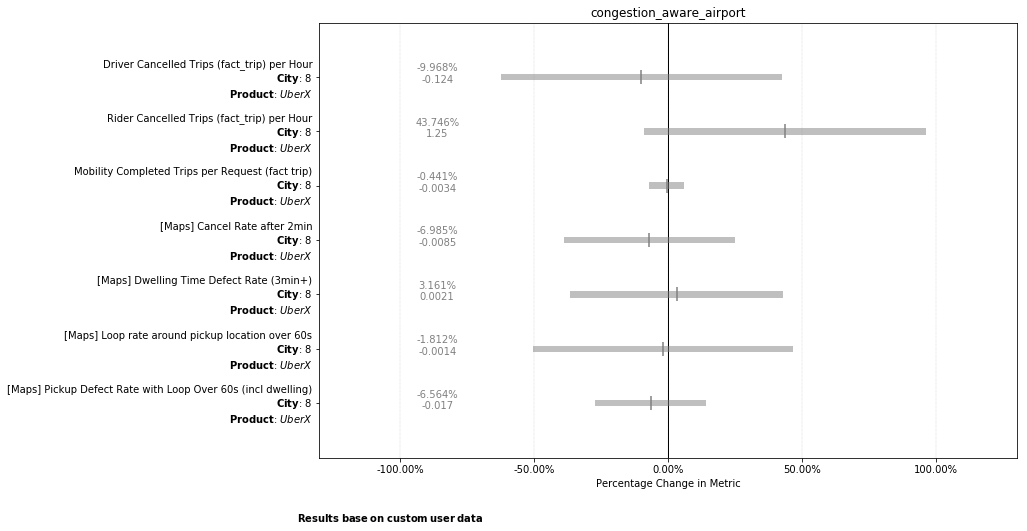

In [11]:
sb.results_barchart()

In [ ]:
sb.time_of_week_plot()

In [ ]:
sb.results_table()

## PLE Analysis

2023-02-20 23:43:13,764 mxpkg.stats.switchback_utils WARNING Dropping the following column from design matrix because of collinearity: C(WOY)[38]
2023-02-20 23:43:14,306 mxpkg.stats.switchback_utils WARNING Dropping the following column from design matrix because of collinearity: C(WOY)[38.0]
2023-02-20 23:43:14,535 mxpkg.services.analysis.report INFO Could not add MX logo to plot


(<Figure size 900x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3a34a02c18>)

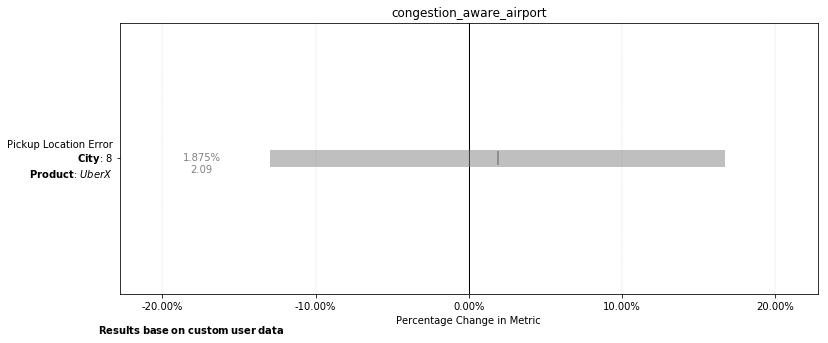

In [12]:
from mxpkg.entities.analysis.segment import Segment, SegmentType
from mxpkg.entities.analysis.switchback import SwitchbackExperimentAnalysisConfig, SwitchbackMetricAnalysisConfig

sb2 = SwitchbackAnalysis(
    metric_names=[],
    experiment_name='congestion_aware_airport',
    segment_filters={
        'product': ['UberX MASTER'], 
        'city': [8]
    },
    segment_types=['city'],
    custom_metrics=[{
    'metric': {
        'is_custom': True,
        'metric_func_name': 'pickup_location_error',
        'description': '[Maps] Average pickup location error (capped at 300m) for all the completed trips',
        'title': 'Pickup Location Error',
        'metric_type': 'Rate',
        'direction': 'DOWN',
        'log': False
    },
    'control_dummies': ["WOY"],
    "absorb_dummy": "TOW",
    'separate_regression_segments': [
        Segment({'segment_type': SegmentType.CITY})
    ],
    'weighting_metric': {
        'metric_func_name': 'ftl_trip_cnt',
        'description': 'Count of trip_uuid in fact_trip_location, (to use as denominator for defect rate metrics)',
        'title': '[Maps] Count of trip_uuid in fact_trip_location',
        'metric_type': 'Level',
        'direction': 'UP',
        'log': False
    },
}]
)

sb2.load_data('query_results_epudos_dc.csv')
sb2.run_analysis()
sb2.results_barchart()

In [ ]:
sb2.time_of_week_plot()

## Congestion Balance

In [13]:
query = """
SELECT
maps_fact_trip_location.datestr AS datestr,
CAST(maps_fact_trip_location.city_id AS VARCHAR) AS city,
maps_fact_trip_location.driver_uuid AS supply_uuid,
maps_fact_trip_location.client_uuid AS rider_uuid,
CAST(
    to_unixtime(
    DATE_PARSE(
        REPLACE(
        substr(
            CAST(
            maps_fact_trip_location.request_timestamp_utc AS VARCHAR
            ),
            1,
            19
        ),
        'T',
        ' '
        ),
        '%Y-%m-%d %H:%i:%s'
    )
    ) AS BIGINT
) * 1000 AS "time",
CAST(
    maps_fact_trip_location.vehicle_view_id AS VARCHAR
) AS vvid,
maps_fact_trip_location.trip_uuid AS trip_uuid,
maps_fact_trip_location.city_id AS city_id,
maps_fact_trip_location.driver_uuid AS driver_uuid,
maps_fact_trip_location.client_uuid AS client_uuid,
maps_fact_trip_location.status AS status,
maps_fact_trip_location.device_os AS device_os,
maps_fact_trip_location.app_version AS app_version,
maps_fact_trip_location.request_timestamp_utc AS request_timestamp_utc,
maps_fact_trip_location.vehicle_view_id AS vehicle_view_id,
maps_fact_trip_location.driver_pickup_dwelling_seconds AS driver_pickup_dwelling_seconds,
maps_fact_trip_location.loops_around_pickup_waste_seconds AS loops_around_pickup_waste_seconds,
maps_fact_trip_location.pickup_waypoint_location_source AS pickup_waypoint_location_source,
maps_fact_trip_location.pickup_waypoint_location_type AS pickup_waypoint_location_type,
maps_fact_trip_location.pickup_anchor_confidence AS pickup_anchor_confidence,
maps_fact_trip_location.trip_cancel_epoch AS trip_cancel_epoch,
maps_fact_trip_location.last_dispatch_accept_epoch AS last_dispatch_accept_epoch,
maps_fact_trip_location.is_rider_cancel_at_dispatch AS is_rider_cancel_at_dispatch,
maps_fact_trip_location.is_rider_cancel_enroute AS is_rider_cancel_enroute,
maps_fact_trip_location.is_rider_cancel_arrived AS is_rider_cancel_arrived,
maps_fact_trip_location.count_driver_accepts AS count_driver_accepts,
maps_fact_trip_location.count_driver_cancels AS count_driver_cancels,
maps_fact_trip_location.count_driver_cancels_enroute AS count_driver_cancels_enroute,
maps_fact_trip_location.count_driver_cancels_arrived AS count_driver_cancels_arrived,
maps_fact_trip_location.is_airport_trip AS is_airport_trip,
maps_fact_trip_location.destination_airport_code AS destination_airport_code,
maps_fact_trip_location.dropoff_airport_code AS dropoff_airport_code,
maps_fact_trip_location.request_airport_code AS request_airport_code,
maps_fact_trip_location.begintrip_airport_code AS begintrip_airport_code,
maps_fact_trip_location.is_airport_destination AS is_airport_destination,
maps_fact_trip_location.is_airport_request AS is_airport_request,
maps_fact_trip_location.pickup_location_error AS pickup_location_error,
maps_fact_trip_location.normalized_pickup_location_error AS normalized_pickup_location_error,
maps_fact_trip_location.zone_uuid AS zone_uuid,
maps_fact_trip_location.access_point_uuid AS access_point_uuid,
dim_product_type.global_parent_name AS global_product_name,
(
    CAST(
    to_unixtime(
        DATE_PARSE(
        REPLACE(
            substr(
            CAST(
                maps_fact_trip_location.request_timestamp_utc AS VARCHAR
            ),
            1,
            19
            ),
            'T',
            ' '
        ),
        '%Y-%m-%d %H:%i:%s'
        )
    ) AS BIGINT
    ) * 1000 - 1662696000000
) / 2880000 * 2880000 + 1662696000000 AS time_bucket
FROM
(
    SELECT
    ft.trip_uuid,
    ft.city_id,
    ft.datestr,
    ft.driver_uuid,
    ft.client_uuid,
    ft.status,
    ft.device_os,
    ft.app_version,
    ft.request_timestamp_utc,
    ft.vehicle_view_id,
    ft.driver_pickup_dwelling_seconds,
    ft.loops_around_pickup_waste_seconds,
    ft.pickup_waypoint_location_source,
    ft.pickup_waypoint_location_type,
    ft.pickup_anchor_confidence,
    ft.pickup_location_error,
    ft.normalized_pickup_location_error,
    a.trip_cancel_epoch,
    a.last_dispatch_accept_epoch,
    a.is_rider_cancel_at_dispatch,
    a.is_rider_cancel_enroute,
    a.is_rider_cancel_arrived,
    a.count_driver_accepts,
    a.count_driver_cancels,
    a.count_driver_cancels_enroute,
    a.count_driver_cancels_arrived,
    f.is_airport_trip,
    f.destination_airport_code,
    f.dropoff_airport_code,
    f.request_airport_code,
    f.begintrip_airport_code,
    e.zone_uuid,
    e.access_point_uuid,
    CASE
        WHEN f.destination_airport_code IS NOT NULL THEN TRUE
        ELSE FALSE
    END AS is_airport_destination,
    CASE
        WHEN f.request_airport_code IS NOT NULL THEN TRUE
        ELSE FALSE
    END AS is_airport_request
    FROM
    maps_etl.fact_trip_location AS ft
    LEFT JOIN dwh.analytics_trip AS a ON a.trip_uuid = ft.trip_uuid
    AND (
        a.datestr >= '2022-09-08'
        AND a.datestr <= '2022-09-24'
    )
    LEFT JOIN restricted_dwh.fact_trip AS f ON f.uuid = ft.trip_uuid
    AND (
        f.datestr >= '2022-09-08'
        AND f.datestr <= '2022-09-24'
    )
    JOIN epudos.fact_epudo_trip AS e ON e.trip_uuid = ft.trip_uuid
    AND (
        e.datestr >= '2022-09-08'
        AND e.datestr <= '2022-09-24'
        AND e.trip_type = 'pickup'
        AND e.flow_type != 'none'
        AND e.zone_uuid IN ('60701719-a03f-4e08-b84b-cde701650676', '309fd9a5-321a-4622-b127-71defe1c39d1')
    )
    WHERE
    ft.datestr >= '2022-09-09'
    AND ft.datestr <= '2022-09-23'
    AND ft.status <> 'fare_split'
    AND (
        ft.device_os = 'ios'
        AND substr(ft.app_version, 1, 1) = '3'
        OR ft.device_os = 'android'
        AND substr(ft.app_version, 1, 1) = '4'
    )
) AS maps_fact_trip_location
LEFT JOIN dwh.lookup_product_vehicle_view AS lookup_product_vehicle_view ON CAST(
    lookup_product_vehicle_view.vehicle_view_id AS VARCHAR
) = CAST(
    maps_fact_trip_location.vehicle_view_id AS VARCHAR
)
LEFT JOIN dwh.dim_product_type AS dim_product_type ON dim_product_type.uuid = lookup_product_vehicle_view.product_type_uuid
"""

In [14]:
cursor = qr.execute('presto', query, pii=True, tier_metadata={'tier':3})
cursor.fetchall()

df3 = cursor.to_pandas()
df3 = df3[(df3['global_product_name'] == 'UberX MASTER')
          & (df3['city'] == 8)
          & (df3['time'] < 1663905600000)
          & (df3['time'] >= 1662696000000)]

02/20/2023 11:43:14 PM Send tier_metadata {'tier': 3} to Queryrunner V2.
02/20/2023 11:43:14 PM  [Polling] b30866c5-5546-4d02-bbc8-3d68719492e6 
02/20/2023 11:43:14 PM  [Status] created 
02/20/2023 11:43:15 PM  [Status] finished validation 
02/20/2023 11:43:17 PM  [Status] started waiting to execute 
02/20/2023 11:43:18 PM  [Status] started execution 
02/20/2023 11:43:54 PM  [Status] completed success 
02/20/2023 11:43:54 PM  [Query Success] completed success 


In [15]:
data = pd.concat([df3], ignore_index=True)

In [16]:
from collections import defaultdict

zone2ap = defaultdict(set)
for _, row in data.iterrows():
    if row['access_point_uuid'] != '\\N':
        zone2ap[row['zone_uuid']].add(row['access_point_uuid'])

In [17]:
data['local_time'] = data.apply(lambda row: pd.to_datetime(row['time'], unit='ms').tz_localize('UTC').tz_convert(city_to_timezone[row['city']]).strftime(DstDateRangeTools.DATESTR_FMT), axis=1)
data['local_time_bucket'] = data.apply(lambda row: pd.to_datetime(row['time_bucket'], unit='ms').tz_localize('UTC').tz_convert(city_to_timezone[row['city']]).strftime(DstDateRangeTools.DATESTR_FMT), axis=1)

In [18]:
data['local_time_ts'] = data.apply(lambda row: pd.to_datetime(row['time'], unit='ms').tz_localize('UTC').tz_convert(city_to_timezone[row['city']]).tz_localize(None), axis=1)
data['local_time_bucket_ts'] = data.apply(lambda row: pd.to_datetime(row['time_bucket'], unit='ms').tz_localize('UTC').tz_convert(city_to_timezone[row['city']]).tz_localize(None), axis=1)

In [19]:
from tqdm import tqdm

cities = [8]
time_range = pd.date_range(start='9/9/2022', end='9/23/2022', freq='10min')
congestion_balance = []

for city_id in tqdm(cities):
    trips = data[data['city'] == city_id]
    for i, (start_time, end_time) in enumerate(zip(time_range, time_range[1:])):
        trips_subset = trips[(start_time <= trips['local_time_ts']) & (trips['local_time_ts'] < end_time)]
        if trips_subset.shape[0]:
            congestion_balance.append([city_id, trips_subset['access_point_uuid'].value_counts().std(), trips_subset['local_time_bucket_ts'].tolist()[0]])

100%|██████████| 1/1 [00:04<00:00,  4.32s/it]


In [20]:
congestion_balance_df = pd.DataFrame(congestion_balance, columns=['city', 'congestion_balance', 'time'])
congestion_balance_df = congestion_balance_df.fillna(0)
congestion_balance_metric = congestion_balance_df.groupby(by=['city', 'time']).mean().reset_index()

In [21]:
sb3_data_df = switch_df.merge(congestion_balance_metric, how='left', on=['time', 'city'])
sb3_data_df['grouping_flag'] = sb3_data_df.apply(lambda row: 0, axis=1)

2023-02-20 23:44:13,106 mxpkg.stats.switchback_utils WARNING Dropping the following column from design matrix because of collinearity: C(WOY)[36]
2023-02-20 23:44:13,706 mxpkg.stats.switchback_utils WARNING Dropping the following column from design matrix because of collinearity: C(WOY)[38.0]
2023-02-20 23:44:14,020 mxpkg.services.analysis.report INFO Could not add MX logo to plot


(<Figure size 900x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3a2fe48048>)

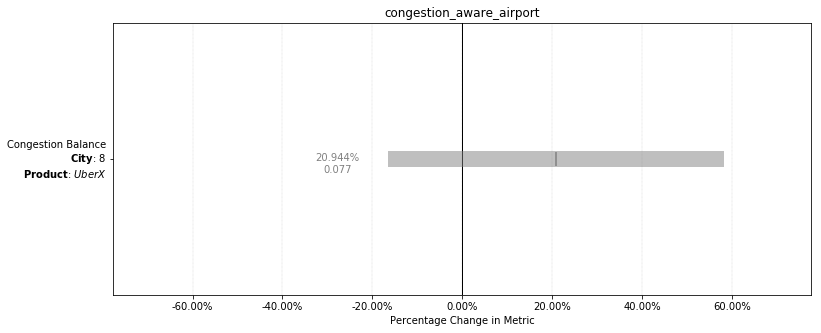

In [22]:
sb3 = SwitchbackAnalysis(
    metric_names=[],
    experiment_name='congestion_aware_airport',
    segment_filters={
        'product': ['UberX MASTER'], 
        'city': [8]
    },
    segment_types=['city'],
    custom_metrics=[{
    'metric': {
        'is_custom': True,
        'metric_func_name': 'congestion_balance',
        'description': '[Maps] Average of standard deviation of num trips within each subzone every 10 mins',
        'title': 'Congestion Balance',
        'metric_type': 'Rate',
        'direction': 'DOWN',
        'log': False
    },
    'control_dummies': ["WOY"],
    "absorb_dummy": "TOW",
    'separate_regression_segments': [
        Segment({'segment_type': SegmentType.CITY})
    ]
}]
)

sb3.data_df = sb3_data_df
sb3.run_analysis()
sb3.results_barchart()

2023-02-20 23:44:14,315 mxpkg.services.analysis.switchback INFO 'product' not found in dataframe. Skipping this segment filter.


[(<Figure size 720x360 with 1 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f3a2f875a20>)]

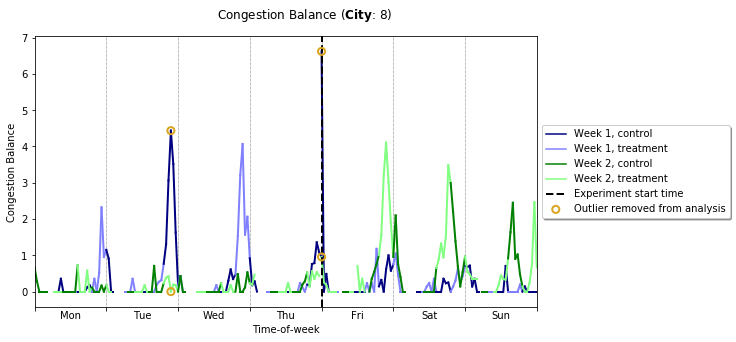

In [23]:
sb3.time_of_week_plot()

### Congestion Balance: Before vs During XP

In [ ]:
query = """
SELECT
maps_fact_trip_location.datestr AS datestr,
CAST(maps_fact_trip_location.city_id AS VARCHAR) AS city,
maps_fact_trip_location.trip_uuid AS trip_uuid,
maps_fact_trip_location.city_id AS city_id,
maps_fact_trip_location.status AS status,
maps_fact_trip_location.request_timestamp_utc AS request_timestamp_utc,
maps_fact_trip_location.vehicle_view_id AS vehicle_view_id,
maps_fact_trip_location.is_airport_trip AS is_airport_trip,
maps_fact_trip_location.request_airport_code AS request_airport_code,
maps_fact_trip_location.begintrip_airport_code AS begintrip_airport_code,
maps_fact_trip_location.is_airport_request AS is_airport_request,
maps_fact_trip_location.zone_uuid AS zone_uuid,
maps_fact_trip_location.access_point_uuid AS access_point_uuid,
dim_product_type.global_parent_name AS global_product_name
FROM
(
    SELECT
    ft.trip_uuid,
    ft.city_id,
    ft.datestr,
    ft.driver_uuid,
    ft.client_uuid,
    ft.status,
    ft.device_os,
    ft.app_version,
    ft.request_timestamp_utc,
    ft.vehicle_view_id,
    ft.driver_pickup_dwelling_seconds,
    ft.loops_around_pickup_waste_seconds,
    ft.pickup_waypoint_location_source,
    ft.pickup_waypoint_location_type,
    f.is_airport_trip,
    f.request_airport_code,
    f.begintrip_airport_code,
    e.zone_uuid,
    e.access_point_uuid,
    CASE
        WHEN f.request_airport_code IS NOT NULL THEN TRUE
        ELSE FALSE
    END AS is_airport_request
    FROM maps_etl.fact_trip_location AS ft
    LEFT JOIN dwh.analytics_trip AS a ON a.trip_uuid = ft.trip_uuid
    AND (
        a.datestr >= '2022-08-25'
        AND a.datestr <= '2022-09-24'
    )
    LEFT JOIN restricted_dwh.fact_trip AS f ON f.uuid = ft.trip_uuid
    AND (
        f.datestr >= '2022-08-25'
        AND f.datestr <= '2022-09-24'
    )
    JOIN epudos.fact_epudo_trip AS e ON e.trip_uuid = ft.trip_uuid
    AND (
        e.datestr >= '2022-08-25'
        AND e.datestr <= '2022-09-24'
        AND e.trip_type = 'pickup'
        AND e.flow_type != 'none'
        AND e.zone_uuid IN ('60701719-a03f-4e08-b84b-cde701650676', '309fd9a5-321a-4622-b127-71defe1c39d1')
    )
    WHERE
    ft.datestr >= '2022-08-25'
    AND ft.datestr <= '2022-09-23'
    AND ft.status <> 'fare_split'
    AND (
        ft.device_os = 'ios'
        AND substr(ft.app_version, 1, 1) = '3'
        OR ft.device_os = 'android'
        AND substr(ft.app_version, 1, 1) = '4'
    )
) AS maps_fact_trip_location
LEFT JOIN dwh.lookup_product_vehicle_view AS lookup_product_vehicle_view ON CAST(
    lookup_product_vehicle_view.vehicle_view_id AS VARCHAR
) = CAST(
    maps_fact_trip_location.vehicle_view_id AS VARCHAR
)
LEFT JOIN dwh.dim_product_type AS dim_product_type ON dim_product_type.uuid = lookup_product_vehicle_view.product_type_uuid
"""

In [ ]:
cursor = qr.execute('presto', query, pii=False, tier_metadata={'tier':3})
# cursor.fetchall()

new_df = cursor.to_pandas()
new_df = new_df[new_df['status'] == 'completed']
new_df = new_df[new_df['global_product_name'] == 'UberX MASTER']